In [1]:
%matplotlib inline
import sys
import os
DATA_PATH = os.getenv('DATA_PATH')
CODE_PATH = os.getenv('CODE_PATH')
FIGURE_PATH = os.getenv('FIGURE_PATH')

sys.path.insert(0, os.path.join(CODE_PATH))

import pandas as pd
import numpy as np
import json
import re

import time

from src.load import EGRID, BA_DATA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from calendar import month_abbr

import logging.config
logging.config.fileConfig(os.path.join(CODE_PATH, "src/logging.conf"))
logger = logging.getLogger(__name__)
                           
COLORS = sns.color_palette('dark')

os.makedirs(os.path.join(FIGURE_PATH, "si"), exist_ok=True)

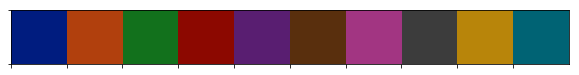

In [2]:
sns.palplot(COLORS)

In [3]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [6.99, 2.5]
plt.rcParams['grid.color'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.size'] = 10

In [4]:
co2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_H.csv"), variable="CO2")
elec = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_E_H.csv"), variable="E")
co2i = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_EFs_CO2_H.csv"), variable="CO2i")

In [5]:
Pacific = -7
Mountain = -6
Arizona = -6
Eastern = -4
Central = -5
ba_dict = {"CISO":Pacific, "BPAT":Pacific, "NWMT":Mountain,
           "MISO":Eastern, "PJM":Eastern, "AZPS":Arizona,
           "ERCO":Central, "SWPP":Central, "PACW":Pacific,
           "SOCO":Central, "NYIS":Eastern, "ISNE":Eastern,
           "FPL":Eastern, "ERCO":Central, "TVA":Central,
           "DUK":Eastern, "CPLE":Eastern, "WACM":Arizona,
           "FPC":Eastern, "PSCO":Mountain, "PACE":Mountain,
           "SRP":Arizona, "WWA":Mountain, "GWA":Mountain,
           "PSEI":Pacific, "IPCO":Pacific, "SPA":Central,
           "OVEC":Eastern, "NEVP":Pacific, "BANC":Pacific,
           "LDWP":Pacific, "PNM":Arizona}

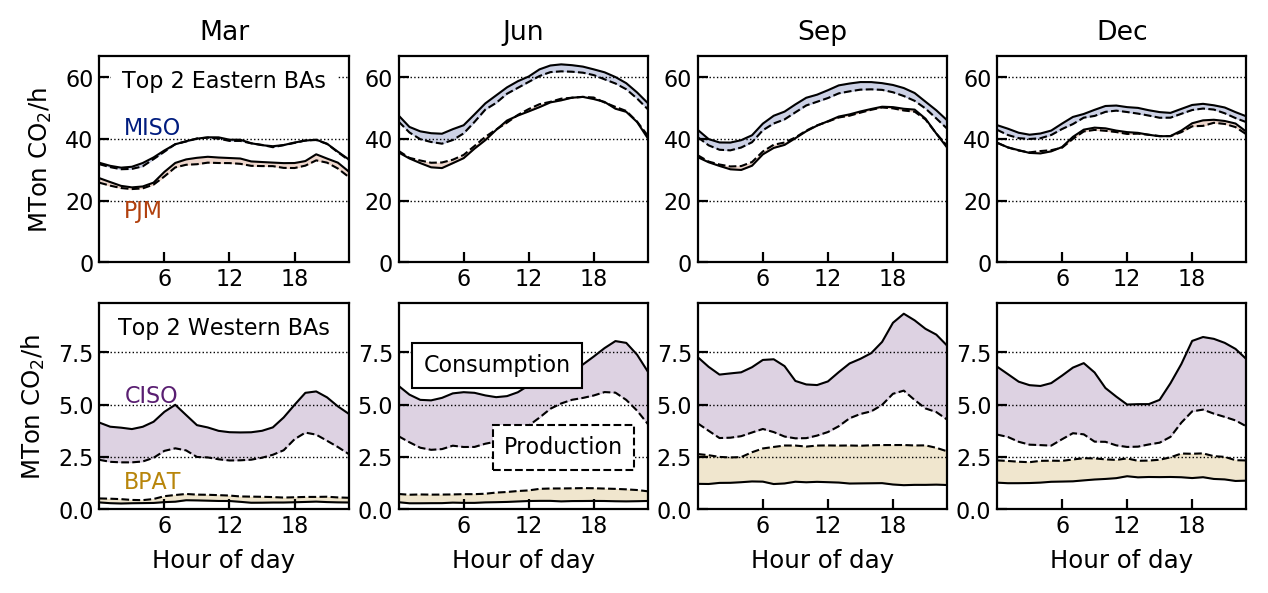

In [6]:
# Main trade plot
def trade_profiles(ba_list=["PJM", "MISO"], saveFig=False, saveNm="main/fig3",
               colors=COLORS, f_and_ax=None, ax_title=True, textypos=[.9, .8],
               subtitle="", with_dash_label=False, x_label=False):
    selected_months = [3,6,9, 12]
    x = np.linspace(0.0, 1.0, len(selected_months))
    if f_and_ax is None:
        f, axes = plt.subplots(1, len(selected_months), figsize=(7.4, 1.5))
    else:
        f, axes = f_and_ax
        
    for iba, ba in enumerate(ba_list):
        df_plot_D = co2.df.loc[:, co2.get_cols(ba, field="D")].copy(deep=True)
        df_plot_NG = co2.df.loc[:, co2.get_cols(ba, field="NG")].copy(deep=True)
        df_plot2 = co2i.df.loc[:, co2i.get_cols(ba, field="D")].copy(deep=True)

        utc_offset = ba_dict[ba]

        for df in [df_plot_D, df_plot_NG, df_plot2]:
            df.index += pd.Timedelta('%dh' % utc_offset)
            df["MONTH"] = df.index.month
            df["HOUR"] = df.index.hour

        grp_co2_D = df_plot_D.loc[:, co2.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()
        grp_co2_NG = df_plot_NG.loc[:, co2.get_cols(ba, field="NG") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()

        label = '_nolegend_'

        for im, m in enumerate(selected_months):
            ax = axes[im]
            if im == 0:
                ax.set_ylabel("MTon CO$_2$/h")
            if (iba == 0) and ax_title:
                ax.set_title(month_abbr[m])

#             ax.plot(grp_co2_D.loc[m, co2.get_cols(ba, field="D")]/1e3,
#                                   label='_nolegend_', color='k', lw=1)
#             ax.plot(grp_co2_NG.loc[m, co2.get_cols(ba, field="NG")]/1e3,
#                                   label='_nolegend_', color='k', lw=1, ls='--')
            ax.plot(grp_co2_D.loc[m, co2.get_cols(ba, field="D")]/1e3,
                                  label='_nolegend_', lw=.75, color='k')
            ax.plot(grp_co2_NG.loc[m, co2.get_cols(ba, field="NG")]/1e3,
                                  label='_nolegend_', lw=.75, ls='--', color='k')
            x = grp_co2_D.loc[m, co2.get_cols(ba, field="D")].index
            y1 = grp_co2_D.loc[m, co2.get_cols(ba, field="D")].values.flatten()/1e3
            y2 = grp_co2_NG.loc[m, co2.get_cols(ba, field="NG")].values.flatten()/1e3
            ax.fill_between(x, y1, y2, interpolate=True, alpha=.2, color=colors[iba])
#             ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True, alpha=.1)
#             ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True, alpha=.1)

            ax.set_xlim([0,23])
            ax.set_xticks([6,12,18])
            if x_label:
                ax.set_xlabel("Hour of day")
            if im == 0:
                ax.text(.1, textypos[iba], ba, color=colors[iba],
                        transform=ax.transAxes, ha='left', va='center',
                        fontsize=8,)
                if iba == 0:
                    ax.text(.5,.88, subtitle, transform=ax.transAxes,
                            ha='center', va='center', fontsize=8,
                            bbox=dict(facecolor='white', edgecolor='none'))
#                 ax.legend(loc=2)
            if (im == 1) & with_dash_label & (iba == 0):
                ax.text(.1,.7, "Consumption", transform=ax.transAxes,
                        ha='left', va='center', fontsize=8,
                        bbox=dict(facecolor='white', lw=.75, edgecolor='k'))
                ax.text(.9,.3, "Production", transform=ax.transAxes,
                        ha='right', va='center', fontsize=8,
                        bbox=dict(facecolor='white', edgecolor='k', lw=.75, ls="--"))
            
            
            ax.tick_params(pad=2, direction='in')
            
        ymax = max([axes[im].get_ylim()[1]*1.01 for im in range(len(selected_months))])
        for im, m in enumerate(selected_months):
            axes[im].set_ylim(bottom=0, top=ymax)
        if saveFig:
            f.savefig(os.path.join(FIGURE_PATH, '%s.pdf' % saveNm), bbox_inches='tight')

# Make plots
f, axes = plt.subplots(2, 4, figsize=(7.4, 3))
for ax in axes.flatten():
    ax.xaxis.grid()
trade_profiles(["MISO", "PJM"], f_and_ax=(f, axes[0]),
           colors=[COLORS[0], COLORS[1]],
           textypos=[.65,.25], subtitle="Top 2 Eastern BAs")
trade_profiles(["CISO", "BPAT"], colors=[COLORS[4], COLORS[8]],
           f_and_ax=(f, axes[1]), textypos=[.55,.13], ax_title=False,
           subtitle="Top 2 Western BAs", with_dash_label=True,
           x_label=True,
           saveFig=True)

In [7]:
# SI trade plots
def trade_profiles_si(ba_list=["PJM", "MISO", "CISO", "BPAT"], saveFig=False, saveNm="main/trade_plot"):
    selected_months = [3,6,9,12]
    x = np.linspace(0.0, 1.0, len(selected_months))

    f, axes = plt.subplots(len(ba_list), len(selected_months), figsize=(7.4, 1.5*len(ba_list)))
    for iba, ba in enumerate(ba_list):
        df_plot_D = co2.df.loc[:, co2.get_cols(ba, field="D")].copy(deep=True)
        df_plot_NG = co2.df.loc[:, co2.get_cols(ba, field="NG")].copy(deep=True)
        df_plot2 = co2i.df.loc[:, co2i.get_cols(ba, field="D")].copy(deep=True)

        utc_offset = ba_dict[ba]

        for df in [df_plot_D, df_plot_NG, df_plot2]:
            df.index += pd.Timedelta('%dh' % utc_offset)
            df["MONTH"] = df.index.month
            df["HOUR"] = df.index.hour

        grp_co2_D = df_plot_D.loc[:, co2.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()
        grp_co2_NG = df_plot_NG.loc[:, co2.get_cols(ba, field="NG") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()

        label = '_nolegend_'

        for im, m in enumerate(selected_months):
            ax = axes[iba, im]
            ax.xaxis.grid()
            if im == 0:
                ax.set_ylabel(ba + " (MTon/h)")
            if iba == 0:
                ax.set_title(month_abbr[m])

            ax.plot(grp_co2_D.loc[m, co2.get_cols(ba, field="D")]/1e3,
                                  label='_nolegend_', color='k', lw=1)
            ax.plot(grp_co2_NG.loc[m, co2.get_cols(ba, field="NG")]/1e3,
                                  label='_nolegend_', color='k', lw=1, ls='--')
            x = grp_co2_D.loc[m, co2.get_cols(ba, field="D")].index
            y1 = grp_co2_D.loc[m, co2.get_cols(ba, field="D")].values.flatten()/1e3
            y2 = grp_co2_NG.loc[m, co2.get_cols(ba, field="NG")].values.flatten()/1e3
            ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
            ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)

            ax.set_xlim([0,23])

            ax.tick_params(pad=2, direction='in')

        ymax = max([axes[iba, im].get_ylim()[1]*1.05 for im in range(len(selected_months))])
        for im, m in enumerate(selected_months):
            axes[iba, im].set_ylim(bottom=0, top=ymax)
        if saveFig:
            f.savefig(os.path.join(FIGURE_PATH, '%s.pdf' % saveNm), bbox_inches='tight')
            plt.close()
            
trade_profiles_si(saveFig=True,saveNm="si/trade_plot0")
trade_profiles_si(ba_list=["NYIS", "ISNE", "AZPS", "IPCO", "FPL", "NEVP"], saveFig=True, saveNm="si/trade_plot1")
trade_profiles_si(ba_list=["ERCO", "SOCO", "SRP", "PACE", "NWMT", "WACM"], saveFig=True, saveNm="si/trade_plot2")